# Solving MNIST with Pytorch
- Choice of the network architecture is up to you
- Goal is to simply get at least 95% accuracy on the test set
- Following [this tutorial](https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
if torch.cuda.is_available():
   print("Your notebook is configured to run on the GPU!")
else:
   print("If you see this message, your notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your notebook is configured to run on the GPU!


## Data Loading
- Transforms (processing image data for model)
    - transforms.ToTensor() — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
    - transforms.Normalize() — normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST('data/MNIST/train', download=False, train=True, transform=transform)
valset = datasets.MNIST('data/MNIST/val', download=False, train=False, transform=transform)

# batch size is the number of images we want to read in one go
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


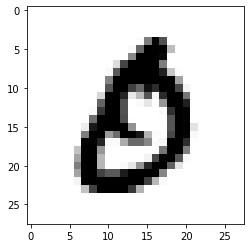

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

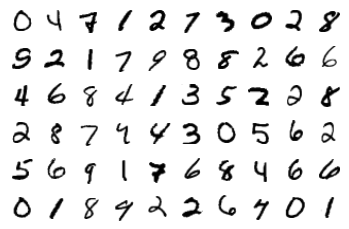

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Neural Network
We will be building the following network, as you can see it contains an input layer (the first layer), an output layer of ten neurons (or units, the circles) and two hidden layers in between.

![](resources/1_HWhBextdDSkxYvz0kEMTVg.png)

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
                      
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


## Training the model

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6568292598766304
Epoch 1 - Training loss: 0.28961939730051994
Epoch 2 - Training loss: 0.22894570036832965
Epoch 3 - Training loss: 0.18687684225565843
Epoch 4 - Training loss: 0.15687871218394878
Epoch 5 - Training loss: 0.13217422407843285
Epoch 6 - Training loss: 0.11771841529311973
Epoch 7 - Training loss: 0.10402304124730483
Epoch 8 - Training loss: 0.09313913817996028
Epoch 9 - Training loss: 0.08353018565083555
Epoch 10 - Training loss: 0.0752435700098144
Epoch 11 - Training loss: 0.06821767603462217
Epoch 12 - Training loss: 0.06374436811849808
Epoch 13 - Training loss: 0.05813158766380442
Epoch 14 - Training loss: 0.05472505813278854

Training Time (in minutes) = 2.142369226614634


## Testing the model and visualising selected metrics
e.g. training loss and test accuracy vs. training iterations

In [12]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 1


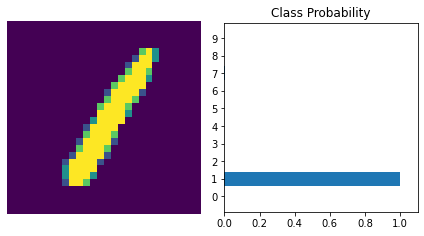

In [13]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [14]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

#torch.save(model, './my_mnist_model.pt') 
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9742
